# Neural Style Transfer

- https://arxiv.org/abs/1508.06576

In [3]:
%matplotlib inline
import importlib
import utils2
from utils2 import *

- xgboostは公式のInstallation Guideにしたがって入れる（Python Packageも）
- pip install gensim
- pip install keras-tqdm
- ToktokTokenizerは削除する（未使用）
- initialization => initializers

In [4]:
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics
from vgg16_avg import VGG16_Avg

- VGG16_AvgはオリジナルのVGGのMax PoolingをAverage Poolingに置き換えたモデル
- 重みはMax Poolingで学習したものをそのまま使っているがよいのだろう？

In [5]:
limit_mem()

In [6]:
path = './data/imagenet/sample/'

## Setup

In [7]:
# ImageNetのサンプル画像のファイル名を取得
fnames = glob.glob(path + '**/*.JPEG', recursive=True)
n = len(fnames)
n

19439

In [8]:
fn = fnames[50]
fn

'./data/imagenet/sample/n01443537/n01443537_7798.JPEG'

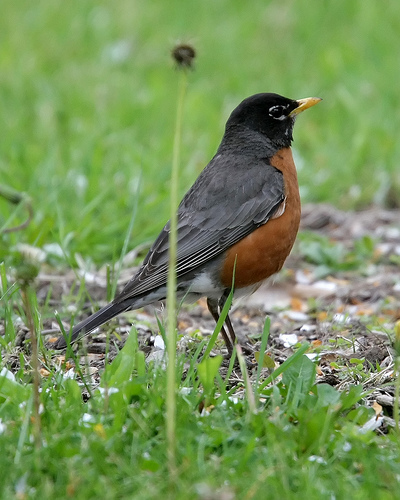

In [9]:
img = Image.open(fnames[315])
img

In [10]:
# ImageNetの学習済み重みを使うための画像前処理
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]

In [11]:
# ネットワークから生成される画像を表示するには上の逆の処理が必要
deproc = lambda x, s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

In [12]:
img_arr = preproc(np.expand_dims(np.array(img), 0))
shp = img_arr.shape
shp

(1, 500, 400, 3)

### Broadcastingの例

In [13]:
np.array([1, 2, 3]) - 2

array([-1,  0,  1])

In [14]:
a = np.array([2, 3])
print(a.shape)
print(a)
a = a.reshape(1, 1, 1, 2)
print(a.shape)
print(a)
a = a.reshape(1, 1, 2, 1)
print(a.shape)
print(a)

(2,)
[2 3]
(1, 1, 1, 2)
[[[[2 3]]]]
(1, 1, 2, 1)
[[[[2]
   [3]]]]


In [15]:
a = np.random.randn(5, 1, 3, 2)
b = np.random.randn(2)
print(a.shape, b.shape)
(a - b).shape

(5, 1, 3, 2) (2,)


(5, 1, 3, 2)

## 入力画像を再現する

In [16]:
model = VGG16_Avg(include_top=False)

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (AveragePooling2 (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (AveragePooling2 (None, None, None, 128)   0         
__________

In [21]:
layer = model.get_layer('block5_conv1').output

In [22]:
layer

<tf.Tensor 'block5_conv1/Relu:0' shape=(?, ?, ?, 512) dtype=float32>

In [37]:
# 指定したレイヤの出力を出力するモデルを新しく構成する
layer_model = Model(model.input, layer)
layer_model.summary()

# 出力をもとにバックプロパゲーションするので処理できるようにVariable化しておく
# targは特定の画像（img_arrに入っている鳥の絵）を入れたときの出力 Variable になる
# 一方、layerは同じレイヤの出力であるが特定の入力を指定していない Tensor になる
targ = K.variable(layer_model.predict(img_arr))
targ

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (AveragePooling2 (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (AveragePooling2 (None, None, None, 128)   0         
__________

<tf.Variable 'Variable_6:0' shape=(1, 31, 25, 512) dtype=float32_ref>

In [31]:
# fmin_l_bfgs_b()を使うにはlossとgradに別々にアクセスできる関数が必要
class Evaluator(object):
    def __init__(self, f, shp):
        # f: lossとgradを返すK.function
        # shp: 入力画像（4D tensor）のサイズ
        self.f, self.shp = f, shp
    
    def loss(self, x):
        # lossとgradがまとめて計算されるのでgradは保存しておく
        loss_, self.grad_values = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)

    def grads(self, x):
        # 保存しておいたgradを返す
        return self.grad_values.flatten().astype(np.float64)

In [35]:
# layerはまだ特定の画像を入れていない出力（あとでmodel.inputとして灰色の画像を入れる）
# targは鳥の画像を入れたときの出力
loss = metrics.mse(layer, targ)

In [36]:
loss

<tf.Tensor 'Mean:0' shape=(?, 31, 25) dtype=float32>

In [38]:
# パラメータではなく、モデルへの入力画像に対する勾配を求める
grads = K.gradients(loss, model.input)

In [50]:
print(type([loss]), type(grads))

<class 'list'> <class 'list'>


In [51]:
[1, 2, 3] + [4, 5, 6]

[1, 2, 3, 4, 5, 6]

In [55]:
# 足し算しても要素がちゃんとわかれている
[loss] + grads

[<tf.Tensor 'Mean:0' shape=(?, 31, 25) dtype=float32>,
 <tf.Tensor 'gradients/block1_conv1/convolution_grad/Conv2DBackpropInput:0' shape=(?, ?, ?, 3) dtype=float32>]

In [49]:
# lossとgradsを結合したリストを返す関数
fn = K.function([model.input], [loss] + grads)

In [56]:
evaluator = Evaluator(fn, shp)

In [57]:
evaluator

In [ ]:
def solve_image(eval_obj, niter, x):
    pass